In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [2]:
from src.utils.auxiliary import flatten_series
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
%matplotlib inline

In [4]:
from projects.ephys.population import to_color

In [5]:
mpl.rcParams.update({'font.size': 13})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# Load data

In [6]:
hffm_savepath = '/home/niell_lab/Desktop'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_041122_sdf')

reading from /home/niell_lab/Desktop/hffm_041122_sdf.pickle


In [7]:
ltdk_savepath = '/home/niell_lab/Desktop'
ltdk = Population(savepath=ltdk_savepath)
ltdk.load(fname='ltdk_041122_sdf')

reading from /home/niell_lab/Desktop/ltdk_041122_sdf.pickle


In [62]:
pdf = PdfPages('/home/niell_lab/Desktop/paperfigs_041522.pdf')

# New colormap

In [9]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))

In [57]:
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}

# for plots shoting continous scatter of 
# for STAs or anything like that: seismic
# cmap for continous plots sorted by peak time: coolwarm (it has grey betwen the tow calues and diverges symetriclly)

# Fig 1

In [11]:
demo = hffm.data[hffm.data['session']=='102621_J558NC_control_Rig2'].iloc[0]

In [12]:
def time_to_ind(eyeT, eventT):
    eventInds = np.zeros(eventT.size)
    for i, t in enumerate(eventT):
        eventInds[i] = np.nanargmin(np.abs(eyeT-t))
    return eventInds

In [77]:
np.nanmax(demo['FmLt_eyeT'])/60

63.56131199166666

In [13]:
dHead_data = demo['FmLt_dHead']
dEye_data = demo['FmLt_dEye_dps']
dGaze_data = demo['FmLt_dGaze']

left = time_to_ind(demo['FmLt_eyeT'], demo['FmLt_gazeshift_left_times_dHead']).astype(int)
right = time_to_ind(demo['FmLt_eyeT'], demo['FmLt_gazeshift_right_times_dHead']).astype(int)
comp = time_to_ind(demo['FmLt_eyeT'], np.hstack([demo['FmLt_comp_left_times_dHead'], demo['FmLt_comp_right_times_dHead']])).astype(int)
other = np.delete(np.arange(0,demo['FmLt_eyeT'].size), np.hstack([comp, left, right]))

In [78]:
left.size + right.size

8346

In [74]:
comp.size

40216

In [30]:
left

array([   265,    266,    301, ..., 228097, 228128, 228224])

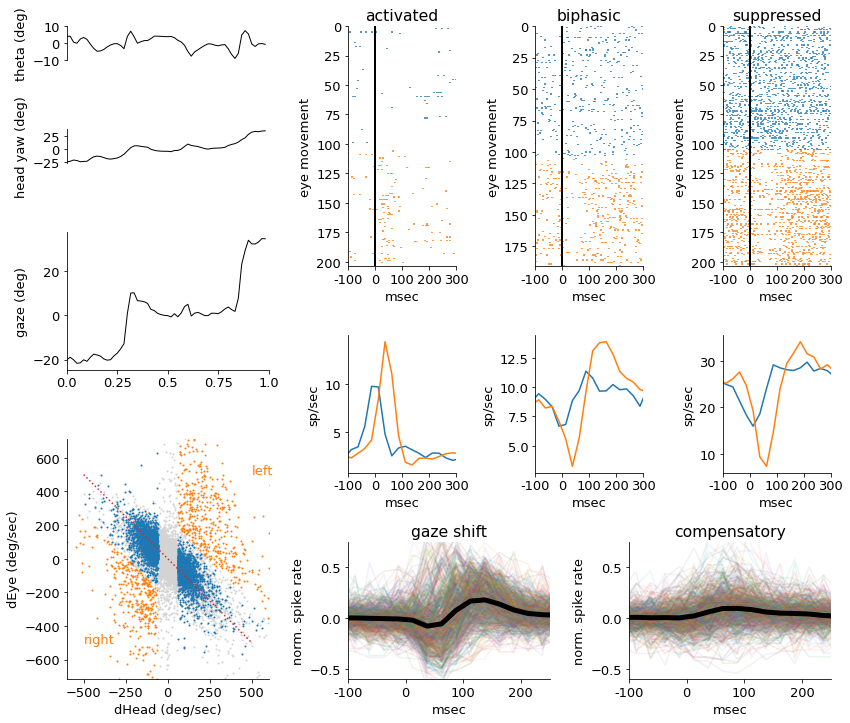

In [63]:
fig = plt.figure(constrained_layout=False, figsize=(12,14))
spec = gridspec.GridSpec(nrows=10, ncols=9, figure=fig)

start = 2090 #2100
win = 60 # frames, not sec
ex_units = [185,82,155]
ex_units_direcprefs = ['left','right','left']

ax_theta = fig.add_subplot(spec[0,0:3])
ax_yaw = fig.add_subplot(spec[1,0:3])
ax_gaze = fig.add_subplot(spec[2:4,0:3])
ax_dEyeHead = fig.add_subplot(spec[4:7,0:3])

ax_pos_raster = fig.add_subplot(spec[0:3,3:5])
ax_biph_raster = fig.add_subplot(spec[0:3,5:7])
ax_neg_raster = fig.add_subplot(spec[0:3,7:9])
ax_pos_sdf = fig.add_subplot(spec[3:5,3:5])
ax_biph_sdf = fig.add_subplot(spec[3:5,5:7])
ax_neg_sdf = fig.add_subplot(spec[3:5,7:9])
ax_mean_gazeshift = fig.add_subplot(spec[5:7,3:6])
ax_mean_comp = fig.add_subplot(spec[5:7,6:9])

theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
ax_theta.plot(theta_data, 'k-', linewidth=1, scaley=10)
ax_theta.set_xlim([0,60]); ax_theta.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_theta.set_ylabel('theta (deg)')
ax_theta.set_ylim([-10,10])
ax_theta.axes.get_xaxis().set_visible(False)
ax_theta.axes.spines.bottom.set_visible(False)

pYaw = np.nancumsum(demo['FmLt_dHead'][start:start+win]*0.016)
pYaw = pYaw - np.nanmean(pYaw)
ax_yaw.plot(pYaw, 'k-', linewidth=1)
ax_yaw.set_xlim([0,60])
ax_yaw.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_yaw.set_ylabel('head yaw (deg)')
ax_yaw.axes.get_xaxis().set_visible(False)
ax_yaw.axes.spines.bottom.set_visible(False)

ax_gaze.plot(pYaw + theta_data, 'k-', linewidth=1)
ax_gaze.set_xlim([0,60])
ax_gaze.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_gaze.set_ylabel('gaze (deg)')

ax_dEyeHead.plot(dHead_data[other[:-1]][::10], dEye_data[other[:-1]][::10], '.', color='lightgray', markersize=2) # other
ax_dEyeHead.plot(dHead_data[left[:-1]][::10], dEye_data[left[:-1]][::10], '.', color='tab:orange', markersize=2) # left
ax_dEyeHead.plot(dHead_data[right[:-1]][::10], dEye_data[right[:-1]][::10], '.', color='tab:orange', markersize=2) # right
ax_dEyeHead.plot(dHead_data[comp[:-1]][::10], dEye_data[comp[:-1]][::10], '.', color='tab:blue', markersize=2) # comp
ax_dEyeHead.axis('equal')
ax_dEyeHead.set_xlim([-600,600])
ax_dEyeHead.set_ylim([-600,600])
ax_dEyeHead.set_xlabel('dHead (deg/sec)')
ax_dEyeHead.set_ylabel('dEye (deg/sec)')
ax_dEyeHead.plot([-500,500],[500,-500], ':', color='tab:red')
ax_dEyeHead.annotate('left', xy=[500,500], color='tab:orange')
ax_dEyeHead.annotate('right', xy=[-500,-500], color='tab:orange')

dwnsmpl_c = 200
dwnsmpl_g = 30

raster_panels = [ax_pos_raster, ax_biph_raster, ax_neg_raster]
sdf_panels = [ax_pos_sdf, ax_biph_sdf, ax_neg_sdf]
for i, u in enumerate(ex_units):
    row = hffm.data.iloc[u]
    raster_panel = raster_panels[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]
    
    gazeshifts = row['FmLt_gazeshift_{}_times_dHead'.format(LR)].copy()
    compmovs = np.hstack([row['FmLt_comp_left_times_dHead'], row['FmLt_comp_right_times_dHead']])
    
    numsacc = int(np.size(compmovs[::dwnsmpl_c]))

    for n, s in enumerate(compmovs[::dwnsmpl_c]):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.3]
        raster_panel.vlines(sp, n-0.5, n+0.5, color='tab:blue')

    for n, s in enumerate(gazeshifts[::dwnsmpl_g]):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.3]
        raster_panel.vlines(sp, (numsacc+n)-0.5, (numsacc+n)+0.5, color='tab:orange')
    
    height = int(np.size(compmovs[::dwnsmpl_c])+np.size(gazeshifts[::dwnsmpl_g]))
    raster_panel.set_ylim([height, 0])
    raster_panel.vlines(0, 0, height, color='k', linewidth=2)
    raster_panel.set_xlabel('msec'); raster_panel.set_ylabel('eye movement')
    raster_panel.set_xticks(np.arange(-0.1,0.4,0.1), labels=np.arange(-100,400,100))
    raster_panel.set_title(['activated','biphasic','suppressed'][i])
    raster_panel.set_xlim([-.1,.3])
    
    sdf_panel.plot(hffm.trange_x, row['FmLt_{}sacc_avg_comp_dHead'.format(LR)], color='tab:blue')
    sdf_panel.plot(hffm.trange_x, row['FmLt_{}sacc_avg_gaze_shift_dHead'.format(LR)], color='tab:orange')
    sdf_panel.set_xticks(np.arange(-0.1,0.4,0.1), labels=np.arange(-100,400,100))
    sdf_panel.set_xlim([-.1,.3])
    
    sdf_panel.set_ylabel('sp/sec'); sdf_panel.set_xlabel('msec')

for ind, row in hffm.data.iterrows():
    ax_mean_gazeshift.plot(hffm.trange_x, row['pref_gazeshift_psth'], alpha=0.1)
    ax_mean_comp.plot(hffm.trange_x, row['nonpref_comp_psth'], alpha=0.1)
ax_mean_gazeshift.plot(hffm.trange_x, np.nanmean(flatten_series(hffm.data['pref_gazeshift_psth']),0), 'k', linewidth=5)
ax_mean_comp.plot(hffm.trange_x, np.nanmean(flatten_series(hffm.data['nonpref_comp_psth']),0), 'k', linewidth=5)
ax_mean_gazeshift.set_title('gaze shift'); ax_mean_gazeshift.set_xlim([-0.1,0.25])
ax_mean_comp.set_title('compensatory'); ax_mean_comp.set_xlim([-0.1,0.25])
ax_mean_comp.set_xlabel('msec'); ax_mean_comp.set_ylabel('norm. spike rate')
ax_mean_gazeshift.set_xlabel('msec'); ax_mean_gazeshift.set_ylabel('norm. spike rate')
ax_mean_comp.set_ylim([-.6,.75]); ax_mean_gazeshift.set_ylim([-.6,.75])
ax_mean_comp.set_xticks(np.arange(-0.1,0.25,0.1), labels=np.arange(-100,250,100))
ax_mean_gazeshift.set_xticks(np.arange(-0.1,0.25,0.1), labels=np.arange(-100,250,100))

plt.tight_layout()

pdf.savefig()

In [80]:
len(hffm.data.index.values)

716

In [81]:
len(hffm.data['session'].unique())

9

# new diagnostic figs

In [ ]:
recording_name = 'test_test'

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(14,7.5))
spec = gridspec.GridSpec(nrows=5, ncols=8, figure=fig)

ax_text = fig.add_subplot(spec[0,0])

ax_worldcamT = fig.add_subplot(spec[0,1])
ax_worldcamT_hist = fig.add_subplot(spec[0,2])

ax_eyecamT = fig.add_subplot(spec[1,1])
ax_eyecamT_hist = fig.add_subplot(spec[1,2])

ax_worldcam_mean = fig.add_subplot(spec[1,0])
ax_worldcam_std = fig.add_subplot(spec[2,0])

ax_text.annotate('Recording: {}'.format(recording_name), color='k', xy=[0,0], fontsize=20)
ax_text.axis('off')

ax_worldcamT.set_xlim('sec'); ax_worldcamT.set_ylim('dT (sec)')

ax_worldcamT.set_xlim('sec'); ax_worldcamT.set_ylim('dT (sec)')

# ax_dEye_and_gyroZ = fig.add_subplot(spec[2,0])

# ax_ephys_max_cc
# ax_ephys_offset_drift

# ax_theta_vs_phi
# ax_theta_vs_pitch
# ax_theta_vs_roll
# ax_phi_vs_roll
# ax_phi_vs_pitch

# ax_dHead_hist
# ax_dTheta_hist
# ax_dGaze_hist

# ax_theta_hist
# ax_phi_hist
# ax_roll_hist
# ax_pitch_hist
# ax_pupil_radius_hist

# ax_raster
# ax_dEye_vs_dHead

# show how much time was spent active

# Fig 2

In [45]:
def plot_cprop_scatter(panel, prop_name, filter_by=[], row=None):
    for c, cluster in enumerate(['early','late','biphasic','negative','unresponsive']):
        if filter_by:
            for filt in filter_by:
                data = hffm.data[hffm.data[filt]==True]
        else:
            data = hffm.data.copy()
        data = data[prop_name][data['movcluster']==cluster]
        x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
        panel.plot(x_jitter, data, '.', color=cat_cmap[cluster])
        panel.hlines(np.mean(data), c-0.2, c+0.2, color='k', linewidth=4)
        panel.set_xticks(range(5), ['early','late','biph.','neg.','uresp.'])
    if row is not None:
        panel.plot(cluster_names.index(row['movcluster']), row[prop_name], '*', color=cat_cmap[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')

In [46]:
for ind, row in hffm.data.iterrows():
    psth = row['pref_gazeshift_raw_psth'].astype(float)
    baseline = np.nanmean(psth[30:47])
    hffm.data.at[ind, 'psth_baseline'] = baseline
for ind in hffm.data.index.values:
    hffm.data.at[ind, 'psth_peakT'] = hffm.trange_x[np.argmax(hffm.data.loc[ind,'pref_gazeshift_raw_psth'][41:51])+41]
sorted_df = hffm.data[['psth_peakT','movcluster','pref_gazeshift_psth','nonpref_gazeshift_psth']].copy()
sorted_df.sort_values(by='psth_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['movcluster']!='unresponsive'].reset_index()
tseq_pref = flatten_series(sorted_df['pref_gazeshift_psth'].copy())
tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth'].copy())

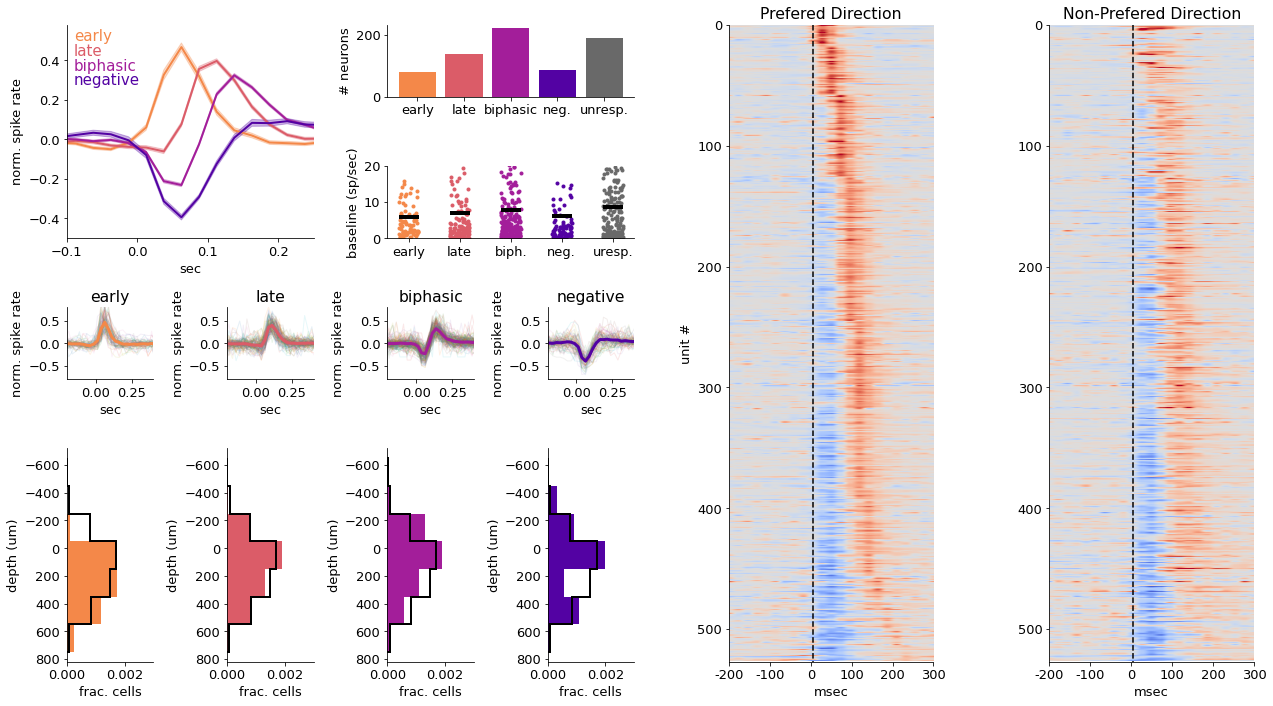

In [64]:
fig = plt.figure(constrained_layout=False, figsize=(18,10))
spec = gridspec.GridSpec(nrows=5, ncols=8, figure=fig)

ax_clusters = fig.add_subplot(spec[0:2,0:2])
ax_cellcounts = fig.add_subplot(spec[0,2:4])
ax_baseline_fr = fig.add_subplot(spec[1,2:4])

ax_early = fig.add_subplot(spec[2,0])
ax_late = fig.add_subplot(spec[2,1])
ax_biphasic = fig.add_subplot(spec[2,2])
ax_negative = fig.add_subplot(spec[2,3])

ax_early_depth = fig.add_subplot(spec[3:5,0])
ax_late_depth = fig.add_subplot(spec[3:5,1])
ax_biphasic_depth = fig.add_subplot(spec[3:5,2])
ax_negative_depth = fig.add_subplot(spec[3:5,3])

ax_tseq_pref = fig.add_subplot(spec[:,4:6])
ax_tseq_nonpref = fig.add_subplot(spec[:,6:8])

step = 0.075

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm.data['pref_gazeshift_psth'][hffm.data['movcluster']==name])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(hffm.trange_x, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_clusters.fill_between(hffm.trange_x, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3)
ax_clusters.set_xlim([-0.1,0.25]); ax_clusters.set_ylim([-.5,.58])
ax_clusters.annotate('early', xy=[-0.09,0.50], color=cat_cmap['early'], fontsize=15)
ax_clusters.annotate('late', xy=[-0.09,0.50-(step*1)], color=cat_cmap['late'], fontsize=15)
ax_clusters.annotate('biphasic', xy=[-0.09,0.50-(step*2)], color=cat_cmap['biphasic'], fontsize=15)
ax_clusters.annotate('negative', xy=[-0.09,0.50-(step*3)], color=cat_cmap['negative'], fontsize=15)
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('sec')

vcounts = hffm.data['movcluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
for i, name in enumerate(names):
    ax_cellcounts.bar(i, vcounts[name], color=cat_cmap[name])
ax_cellcounts.set_xticks(ticks=range(5), labels=['early','late','biphasic','neg.','unresp.'])
ax_cellcounts.set_ylabel('# neurons')

plot_cprop_scatter(ax_baseline_fr, 'psth_baseline')
ax_baseline_fr.set_ylabel('baseline (sp/sec)')
ax_baseline_fr.set_ylim([0,20])

panels = [ax_early, ax_late, ax_biphasic, ax_negative]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    
    thisclust = hffm.data['pref_gazeshift_psth'][hffm.data['movcluster']==movtype]
    for i, psth in enumerate(thisclust):
        panel.plot(hffm.trange_x, psth, '-', linewidth=1, alpha=0.1)
    clustmean = np.nanmean(flatten_series(thisclust),0)
    panel.plot(hffm.trange_x, clustmean, '-', linewidth=3, color=cat_cmap[movtype])
    panel.set_xlim([-0.2,0.4]); panel.set_ylim([-.8,.8])
    panel.set_title(movtype)
    panel.set_ylabel('norm. spike rate'); panel.set_xlabel('sec')

panels = [ax_early_depth, ax_late_depth, ax_biphasic_depth, ax_negative_depth]
names = ['early','late','biphasic','negative']
for i, panel in enumerate(panels):
    name = names[i]
    panel.hist(hffm.data['Wn_depth_from_layer5'], color='k', bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='step', linewidth=2)
    panel.hist(hffm.data['Wn_depth_from_layer5'][hffm.data['movcluster']==name],
                        color=cat_cmap[name], bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='stepfilled')
    panel.set_ylabel('depth (um)')
    panel.set_xlabel('frac. cells')
    panel.invert_yaxis()
    panel.set_xlim(0,0.003)

ax_tseq_pref.set_ylabel('unit #')
ax_tseq_pref.set_xlabel('msec')
ax_tseq_pref.set_ylim([np.size(tseq_pref,0),0])
ax_tseq_pref.set_xlim([31,53])
ax_tseq_pref.set_xticks(np.linspace(31,53,6), labels=np.arange(-200,400,100))
tseq_scale = ax_tseq_pref.imshow(tseq_pref, cmap='coolwarm', vmin=-.8, vmax=.8)
ax_tseq_pref.vlines(40, 0, np.size(tseq_pref,0), color='k', linestyle='dashed')
ax_tseq_pref.set_aspect(0.13)
ax_tseq_pref.set_title('Prefered Direction')

ax_tseq_nonpref.set_xlabel('msec')
ax_tseq_nonpref.set_ylim([np.size(tseq_nonpref,0),0])
ax_tseq_nonpref.set_xlim([31,53])
ax_tseq_nonpref.set_xticks(np.linspace(31,53,6), labels=np.arange(-200,400,100))
ax_tseq_nonpref.imshow(tseq_nonpref, cmap='coolwarm', vmin=-.8, vmax=.8)
ax_tseq_nonpref.vlines(40, 0, np.size(tseq_nonpref,0), color='k', linestyle='dashed')
ax_tseq_nonpref.set_aspect(0.13)
ax_tseq_nonpref.set_title('Non-Prefered Direction')

plt.tight_layout()

pdf.savefig()

# Fig 3

In [65]:
for ind, row in ltdk.data.iterrows():
    psth = row['pref_gazeshift_raw_psth'].astype(float)
    baseline = np.nanmean(psth[30:47])
    ltdk.data.at[ind, 'psth_baseline'] = baseline
for ind in ltdk.data.index.values:
    ltdk.data.at[ind, 'psth_peakT'] = ltdk.trange_x[np.argmax(ltdk.data.loc[ind,'pref_gazeshift_raw_psth'][41:51])+41]
sorted_df = ltdk.data[['psth_peakT','movcluster','pref_gazeshift_psth','pref_gazeshift_psth_FmDk']].copy()
sorted_df.sort_values(by='psth_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['movcluster']!='unresponsive'].reset_index()
tseq_l = flatten_series(sorted_df['pref_gazeshift_psth'].copy())
tseq_d = flatten_series(sorted_df['pref_gazeshift_psth_FmDk'].copy())

In [66]:
model_dt = 0.025
for ind, row in ltdk.data.iterrows():
    modelT = np.arange(0, np.nanmax(row['FmLt_eyeT']), model_dt)
    
    # timing is off sometimes... using eyeT instead of worldT to get maximum length
    # and they can be different by a few frames
    diff = len(modelT) - len(row['FmLt_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmLt_imuT'], row['FmLt_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmLt_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmLt_modelT'] = modelT.astype(object)
    
    modelT = np.arange(0, np.nanmax(row['FmDk_eyeT']), model_dt)
    diff = len(modelT) - len(row['FmDk_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmDk_imuT'], row['FmDk_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmDk_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmDk_modelT'] = modelT.astype(object)

In [67]:
ltdk.data['FmLt_fr'] = ((ltdk.data['FmLt_rate'].apply(np.sum)*0.025) / ltdk.data['FmLt_eyeT'].apply(np.nanmax)).to_numpy()
ltdk.data['FmDk_fr'] = ((ltdk.data['FmDk_rate'].apply(np.sum)*0.025) / ltdk.data['FmDk_eyeT'].apply(np.nanmax)).to_numpy()

In [68]:
FmLt_fr = np.zeros([len(ltdk.data.index.values)])
FmDk_fr = np.zeros([len(ltdk.data.index.values)])
for ind, row in ltdk.data.iterrows():
    ltdk.data.at[ind,'FmLt_active_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']>40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']>40])
    ltdk.data.at[ind,'FmLt_inactive_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']<40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']<40])
    ltdk.data.at[ind,'FmDk_active_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']>40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']>40])
    ltdk.data.at[ind,'FmDk_inactive_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']<40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']<40])

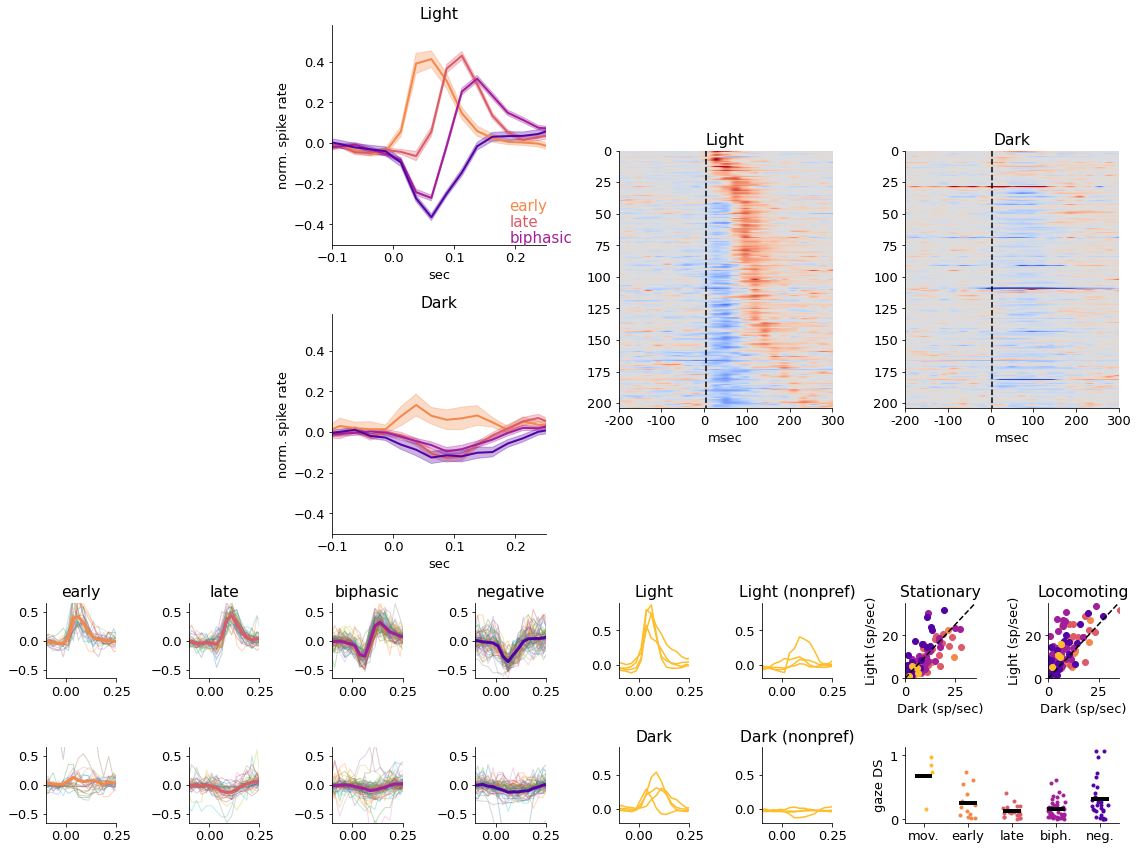

In [69]:
fig = plt.figure(constrained_layout=False, figsize=(16,12))
spec = gridspec.GridSpec(nrows=6, ncols=8, figure=fig)

ax_light_clusters = fig.add_subplot(spec[0:2,2:4])
ax_dark_clusters = fig.add_subplot(spec[2:4,2:4])

ax_early_l = fig.add_subplot(spec[4,0])
ax_late_l = fig.add_subplot(spec[4,1])
ax_biphasic_l = fig.add_subplot(spec[4,2])
ax_negative_l = fig.add_subplot(spec[4,3])

ax_early_d = fig.add_subplot(spec[5,0])
ax_late_d = fig.add_subplot(spec[5,1])
ax_biphasic_d = fig.add_subplot(spec[5,2])
ax_negative_d = fig.add_subplot(spec[5,3])

ax_tseq_l = fig.add_subplot(spec[0:4,4:6])
ax_tseq_d = fig.add_subplot(spec[0:4,6:8])

ax_active_light_pref = fig.add_subplot(spec[4,4])
ax_active_light_nonpref = fig.add_subplot(spec[4,5])
ax_active_dark_pref = fig.add_subplot(spec[5,4])
ax_active_dark_nonpref = fig.add_subplot(spec[5,5])

ax_stationary_fr = fig.add_subplot(spec[4,6])
ax_active_fr = fig.add_subplot(spec[4,7])
ax_gaze_ds = fig.add_subplot(spec[5,6:8])

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth'])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(ltdk.trange_x, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(ltdk.trange_x, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_light_clusters.set_xlim([-0.1,0.25]); ax_light_clusters.set_ylim([-.5,.58])
ax_light_clusters.annotate('early', xy=[0.19,-0.33], color=cat_cmap['early'], fontsize=15)
ax_light_clusters.annotate('late', xy=[0.19,-0.41], color=cat_cmap['late'], fontsize=15)
ax_light_clusters.annotate('biphasic', xy=[0.19,-0.49], color=cat_cmap['biphasic'], fontsize=15)
ax_light_clusters.annotate('negative', xy=[0.19,-0.57], color=cat_cmap['negative'], fontsize=15)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('sec')
ax_light_clusters.set_title('Light')

for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth_FmDk'])
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(ltdk.trange_x, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(ltdk.trange_x, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.1,0.25]); ax_dark_clusters.set_ylim([-.5,.58])
# ax_dark_clusters.annotate('early', xy=[0.19,-0.33], color=cat_cmap['early'], fontsize=15)
# ax_dark_clusters.annotate('late', xy=[0.19,-0.41], color=cat_cmap['late'], fontsize=15)
# ax_dark_clusters.annotate('biphasic', xy=[0.19,-0.49], color=cat_cmap['biphasic'], fontsize=15)
# ax_dark_clusters.annotate('negative', xy=[0.19,-0.57], color=cat_cmap['negative'], fontsize=15)
ax_dark_clusters.set_ylabel('norm. spike rate'); ax_dark_clusters.set_xlabel('sec')
ax_dark_clusters.set_title('Dark')

light_panels = [ax_early_l, ax_late_l, ax_biphasic_l, ax_negative_l]
dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

for count, name in enumerate(names):
    lpanel = light_panels[count]; dpanel = dark_panels[count]
    
    for x in ltdk.data['pref_gazeshift_psth'][ltdk.data['movcluster']==name]:
        lpanel.plot(ltdk.trange_x, x, '-', linewidth=1, alpha=.3)
    lpanel.plot(ltdk.trange_x, np.nanmean(flatten_series(ltdk.data['pref_gazeshift_psth'][ltdk.data['movcluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    lpanel.set_xlim([-.1,0.25]); lpanel.set_ylim([-.65,.65])
    lpanel.set_title(name)
    
    for x in ltdk.data['pref_gazeshift_psth_FmDk'][ltdk.data['movcluster']==name]:
        dpanel.plot(ltdk.trange_x, x, '-', linewidth=1, alpha=.3)
    dpanel.plot(ltdk.trange_x, np.nanmean(flatten_series(ltdk.data['pref_gazeshift_psth_FmDk'][ltdk.data['movcluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    dpanel.set_xlim([-.1,0.25]); dpanel.set_ylim([-.65,.65])
    
ax_tseq_l.set_xlabel('msec')
ax_tseq_l.set_ylim([np.size(tseq_l,0),0])
ax_tseq_l.set_xlim([31,53])
ax_tseq_l.set_xticks(np.linspace(31,53,6), labels=np.arange(-200,400,100))
ax_tseq_l.imshow(tseq_l, cmap='coolwarm', vmin=-.8, vmax=.8)
ax_tseq_l.vlines(40, 0, np.size(tseq_l,0), color='k', linestyle='dashed')
ax_tseq_l.set_aspect(0.13)
ax_tseq_l.set_title('Light')

ax_tseq_d.set_xlabel('msec')
ax_tseq_d.set_ylim([np.size(tseq_d,0),0])
ax_tseq_d.set_xlim([31,53])
ax_tseq_d.set_xticks(np.linspace(31,53,6), labels=np.arange(-200,400,100))
ax_tseq_d.imshow(tseq_d, cmap='coolwarm', vmin=-.8, vmax=.8)
ax_tseq_d.vlines(40, 0, np.size(tseq_d,0), color='k', linestyle='dashed')
ax_tseq_d.set_aspect(0.13)
ax_tseq_d.set_title('Dark')

dark_responding = [61,73,183,186]
for ind in dark_responding:
    ax_active_light_pref.plot(ltdk.trange_x, ltdk.data.loc[ind,'pref_gazeshift_psth'], color=cat_cmap['movement'])
    ax_active_light_nonpref.plot(ltdk.trange_x, ltdk.data.loc[ind,'nonpref_gazeshift_psth'], color=cat_cmap['movement'])
    ax_active_dark_pref.plot(ltdk.trange_x, ltdk.data.loc[ind,'pref_gazeshift_psth_FmDk'], color=cat_cmap['movement'])
    ax_active_dark_nonpref.plot(ltdk.trange_x, ltdk.data.loc[ind,'nonpref_gazeshift_psth_FmDk'], color=cat_cmap['movement'])
ax_active_light_pref.set_xlim([-.1,0.25]); ax_active_light_pref.set_ylim([-.2,.9])
ax_active_light_pref.set_title('Light')
ax_active_dark_pref.set_xlim([-.1,0.25]); ax_active_dark_pref.set_ylim([-.2,.9])
ax_active_dark_pref.set_title('Dark')
ax_active_light_nonpref.set_xlim([-.1,0.25]); ax_active_light_nonpref.set_ylim([-.2,.9])
ax_active_light_nonpref.set_title('Light (nonpref)')
ax_active_dark_nonpref.set_xlim([-.1,0.25]); ax_active_dark_nonpref.set_ylim([-.2,.9])
ax_active_dark_nonpref.set_title('Dark (nonpref)')

for name in names:
    light_iafr = ltdk.data['FmLt_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_iafr = ltdk.data['FmDk_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    light_afr = ltdk.data['FmLt_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_afr = ltdk.data['FmDk_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    for i in range(np.size(light_iafr,0)):
        ax_stationary_fr.plot(dark_iafr[i], light_iafr[i], 'o', color=cat_cmap[name])
        ax_active_fr.plot(dark_afr[i], light_afr[i], 'o', color=cat_cmap[name])
        
    for ind in dark_responding:
        ax_stationary_fr.plot(ltdk.data.loc[ind,'FmDk_inactive_fr'], ltdk.data.loc[ind,'FmLt_inactive_fr'], 'o', color=cat_cmap['movement'])
        ax_active_fr.plot(ltdk.data.loc[ind,'FmDk_active_fr'], ltdk.data.loc[ind,'FmLt_active_fr'], 'o', color=cat_cmap['movement'])
        
fr_axis_max = 35
ax_stationary_fr.set_ylim([0,fr_axis_max]); ax_active_fr.set_ylim([0,fr_axis_max])
ax_stationary_fr.set_xlim([0,fr_axis_max]); ax_active_fr.set_xlim([0,fr_axis_max])
ax_stationary_fr.plot([0,35],[0,35],color='k',linestyle='dashed')
ax_active_fr.plot([0,35],[0,35],color='k',linestyle='dashed')
ax_stationary_fr.set_ylabel('Light (sp/sec)'); ax_stationary_fr.set_xlabel('Dark (sp/sec)')
ax_active_fr.set_title('Locomoting')
ax_active_fr.set_ylabel('Light (sp/sec)'); ax_active_fr.set_xlabel('Dark (sp/sec)')
ax_stationary_fr.set_title('Stationary')

for c, cluster in enumerate(['movement','early','late','biphasic','negative']):
    if cluster != 'movement':
        data = ltdk.data['gaze_sacc_rlMI'][ltdk.data['movcluster']==cluster].copy()
        if cluster=='early':
            data = data.drop(index=dark_responding).to_numpy()
    elif cluster == 'movement':
        data = ltdk.data.loc[dark_responding, 'gaze_sacc_rlMI'].copy().to_numpy()
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    data = np.abs(data)
    ax_gaze_ds.plot(x_jitter, data, '.', color=cat_cmap[cluster])
    ax_gaze_ds.hlines(np.nanmean(data), c-0.2, c+0.2, color='k', linewidth=4)
    ax_gaze_ds.set_xticks(range(5), ['mov.','early','late','biph.','neg.'])
ax_gaze_ds.set_ylabel('gaze DS')

plt.tight_layout()

pdf.savefig()

In [70]:
pdf.close()

In [ ]:
plt.subplots(6,5,figsize=(12,12))
for i, ind in enumerate(ltdk.data[ltdk.data['movcluster']=='early'].index.values):
    plt.subplot(6,5,i+1)
    plt.title(ind)
    plt.plot(ltdk.trange_x, ltdk.data.loc[ind,'pref_gazeshift_psth'], color='k')
    plt.plot(ltdk.trange_x, ltdk.data.loc[ind,'pref_gazeshift_psth_FmDk'], color='tab:red')
    plt.xlim([-0.2,0.5])

# Fig 4

In [ ]:
hffm.data[hffm.data['movcluster']=='negative'].index.values

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(16,12))
spec = gridspec.GridSpec(nrows=6, ncols=8, figure=fig)

ax_early_gaze = fig.add_subplot(spec[0,0])
ax_early_rc = fig.add_subplot(spec[0,1])
ax_early_sn = fig.add_subplot(spec[0,2])
ax_early_wc = fig.add_subplot(spec[0,3])

ax_late_gaze = fig.add_subplot(spec[0,0])
ax_late_rc = fig.add_subplot(spec[0,1])
ax_late_sn = fig.add_subplot(spec[0,2])
ax_late_wc = fig.add_subplot(spec[0,3])

ax_biphasic_gaze = fig.add_subplot(spec[0,0])
ax_biphasic_rc = fig.add_subplot(spec[0,1])
ax_biphasic_sn = fig.add_subplot(spec[0,2])
ax_biphasic_wc = fig.add_subplot(spec[0,3])

ax_negative_gaze = fig.add_subplot(spec[0,0])
ax_negative_rc = fig.add_subplot(spec[0,1])
ax_negative_sn = fig.add_subplot(spec[0,2])
ax_negative_wc = fig.add_subplot(spec[0,3])

early_ex = [16,17,18,27,29]
late_ex = [0,2,3,5,6]
biphasic_ex = [7,8,11,15,19]
negative_ex = [14,47,58,73,75]

response in ['pref_gazeshift_psth', 'norm_Rc_psth','norm_Sn_background_on']
for ni, name in ['early','late','biphasic','negative']:
    panel = example_panels = []
    for ui, unit in range()
ax_early_sacc.plot